In [2]:
%matplotlib inline

import seaborn as sns
import pandas as pd
from pysal.lib import weights
import geopandas as gpd
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster

ModuleNotFoundError: No module named 'pysal'

In [ ]:
# Read the file in
abb = gpd.read_file("london_abb.gpkg")

In [ ]:
# Inspect the structure of the table
abb.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   MSOA_CODE                    353 non-null    object  
 1   accommodates                 353 non-null    float64 
 2   bathrooms                    353 non-null    float64 
 3   bedrooms                     353 non-null    float64 
 4   beds                         353 non-null    float64 
 5   number_of_reviews            353 non-null    float64 
 6   reviews_per_month            353 non-null    float64 
 7   review_scores_rating         353 non-null    float64 
 8   review_scores_accuracy       353 non-null    float64 
 9   review_scores_cleanliness    353 non-null    float64 
 10  review_scores_checkin        353 non-null    float64 
 11  review_scores_communication  353 non-null    float64 
 12  review_scores_location       353 non-null    float64 
 1

In [ ]:
ratings = [
    'review_scores_rating', 
    'review_scores_accuracy', 
    'review_scores_cleanliness', 
    'review_scores_checkin', 
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value'
]

In [ ]:
boroughs = gpd.read_file(
    "https://darribas.org/gds_course/content/data/london_inner_boroughs.geojson"
)

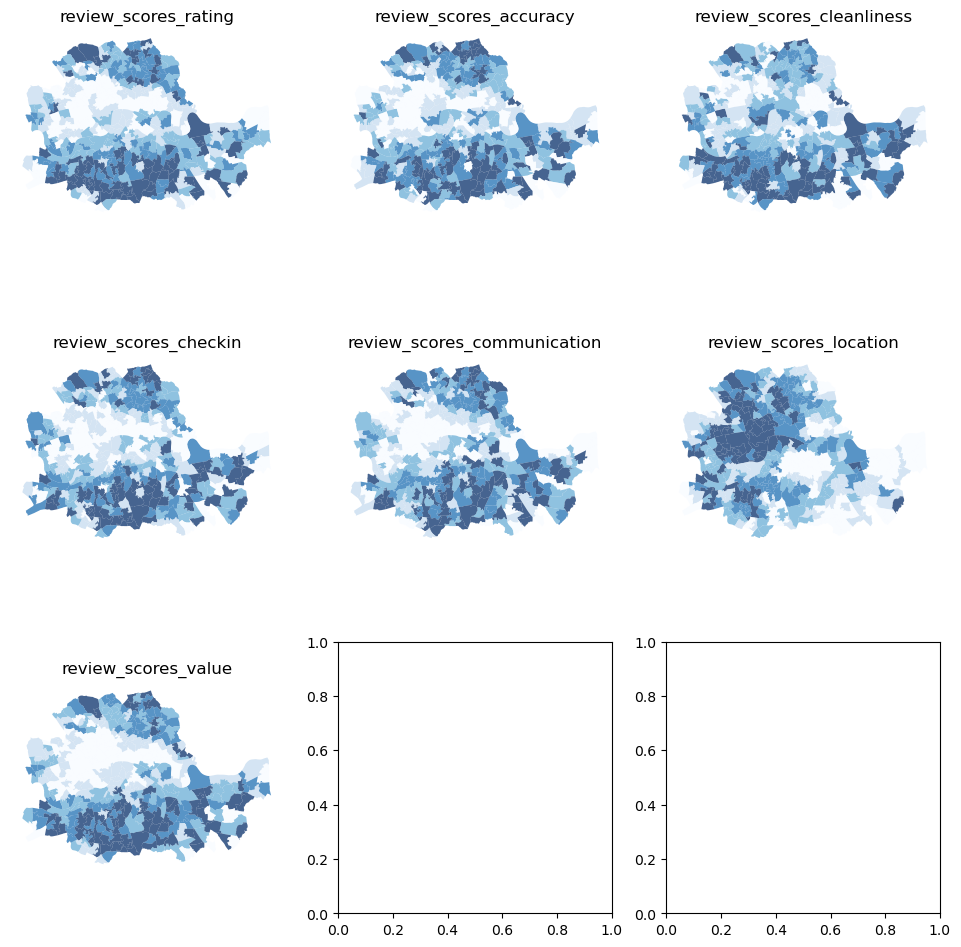

In [ ]:
# Create figure and axes (this time it's 9, arranged 3 by 3)
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the variables of interest
for i, col in enumerate(ratings):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    abb.plot(
        column=col, 
        ax=ax, 
        scheme='Quantiles',
        linewidth=0, 
        cmap='Blues', 
        alpha=0.75
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

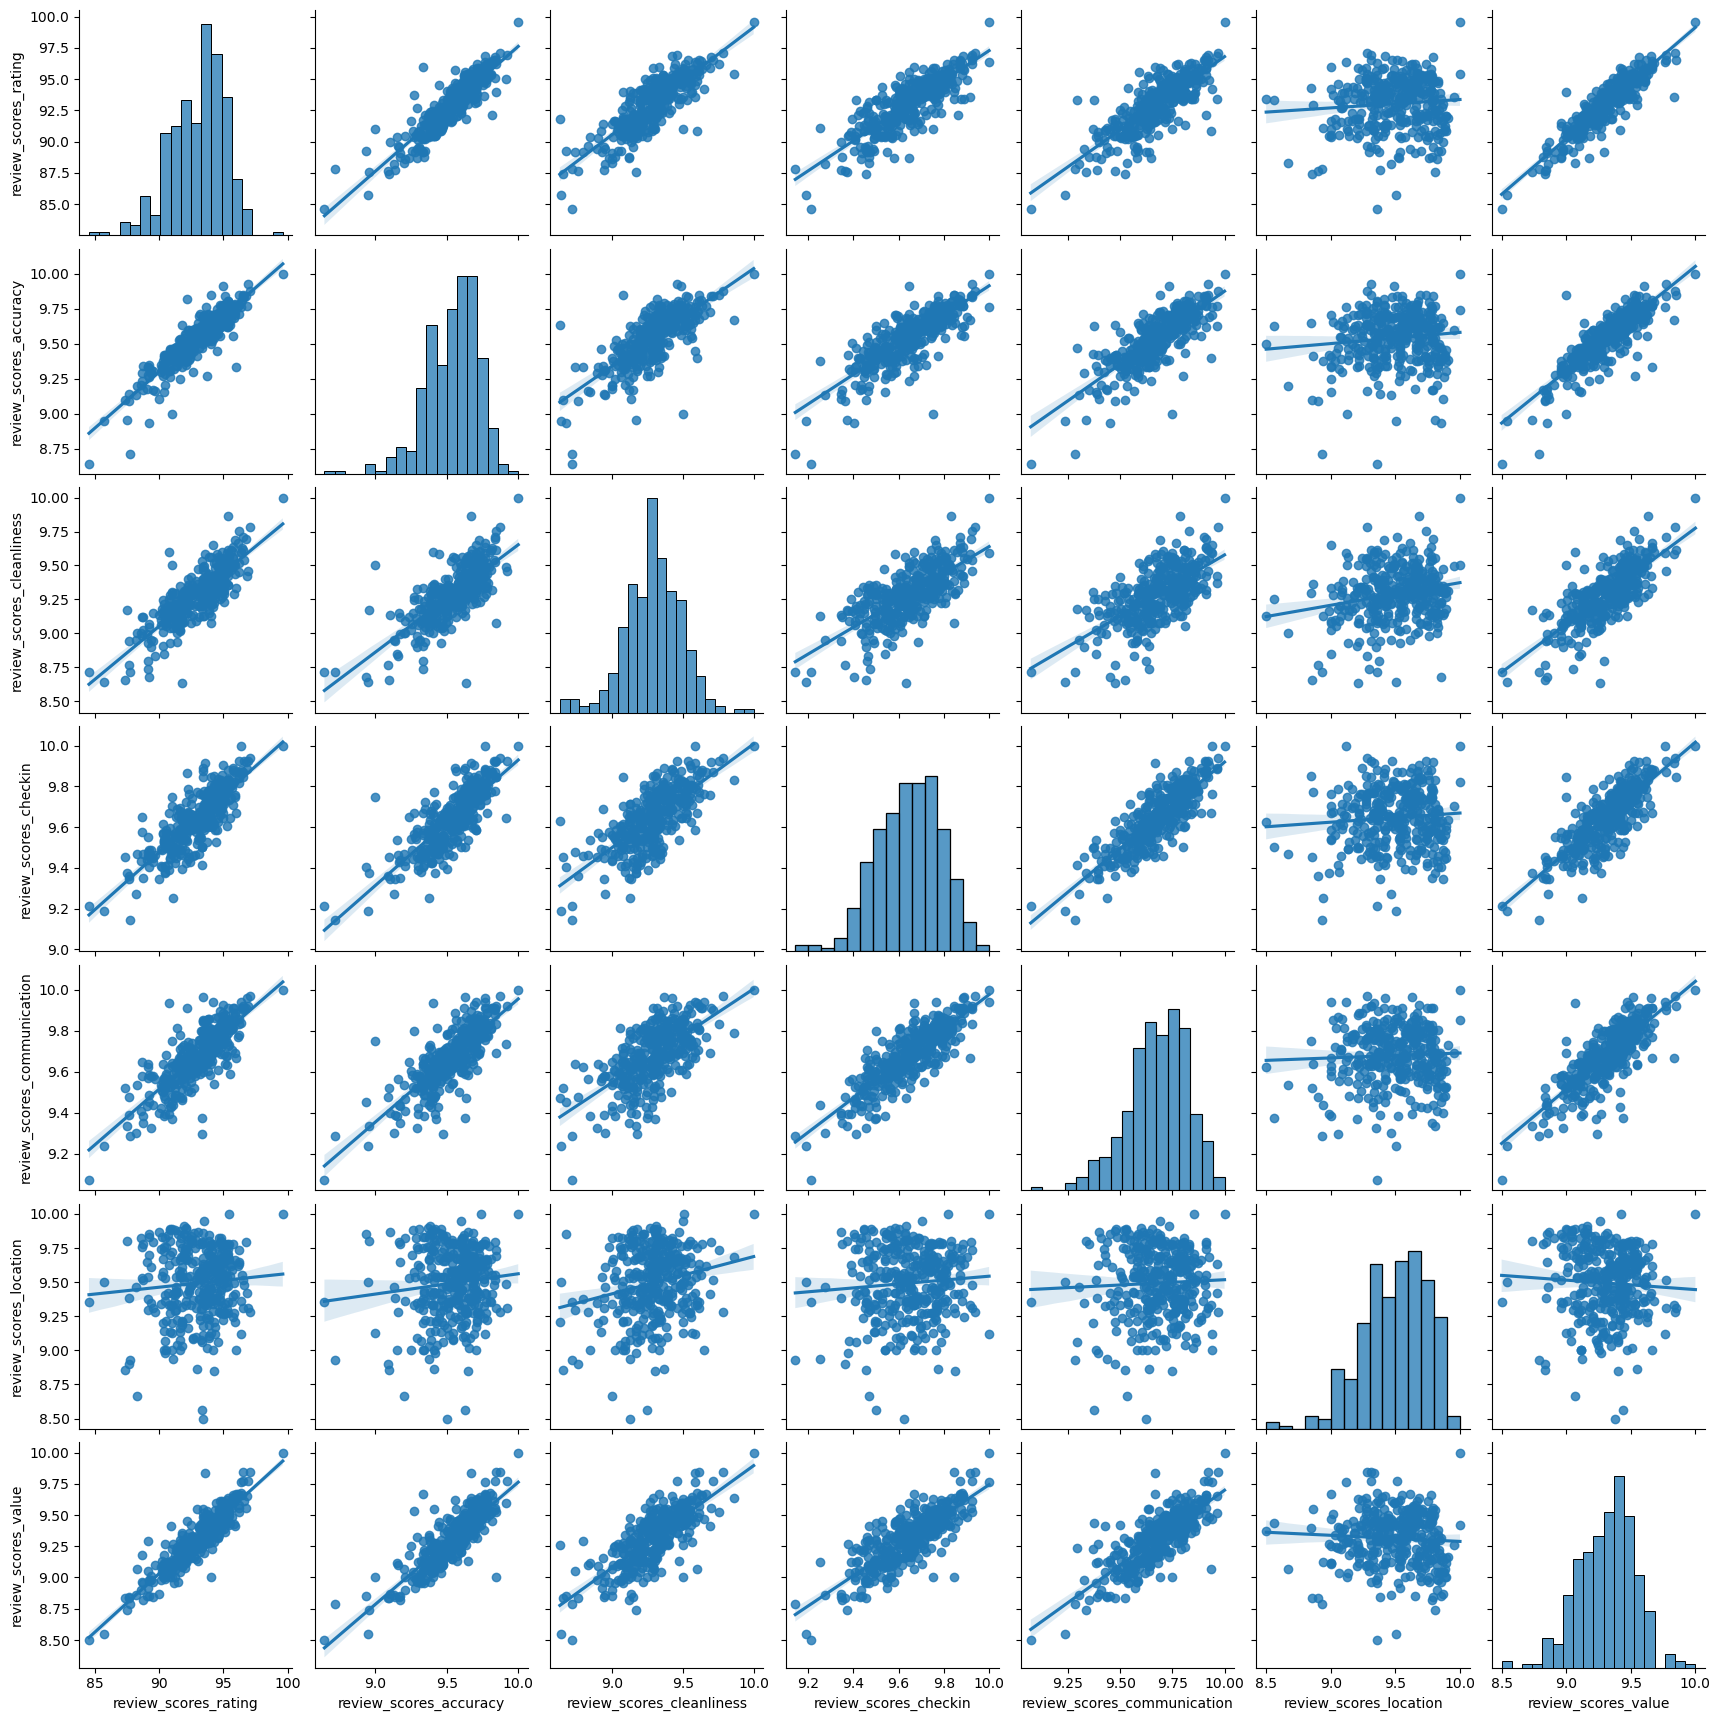

In [ ]:
_ = sns.pairplot(abb[ratings], kind='reg', diag_kind='hist')

In [ ]:
kmeans5 = cluster.KMeans(n_clusters=5, random_state=12345)

In [ ]:
# Run the clustering algorithm
k5cls = kmeans5.fit(abb[ratings])

/home/siquette/anaconda3/envs/ri/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
k5cls.labels_

In [ ]:
abb['k5cls'] = k5cls.labels_

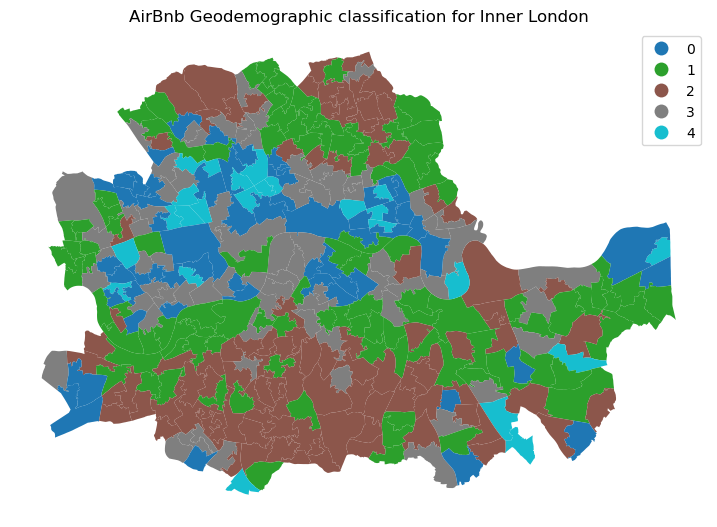

In [ ]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
abb.plot(
    column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('AirBnb Geodemographic classification for Inner London')
# Display the map
plt.show()

In [ ]:
k5sizes = abb.groupby('k5cls').size()
k5sizes

k5cls
0     56
1    104
2     98
3     72
4     23
dtype: int64

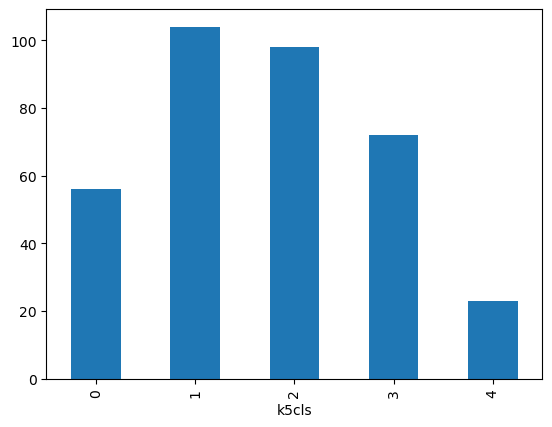

In [ ]:
_ = k5sizes.plot.bar()

In [ ]:
# Calculate the mean by group
k5means = abb.groupby('k5cls')[ratings].mean()
# Show the table transposed (so it's not too wide)
k5means.T

k5cls,0,1,2,3,4
review_scores_rating,90.725593,93.727497,95.330624,92.134328,88.322160
review_scores_accuracy,9.355684,9.605591,9.717272,9.472732,9.149055
review_scores_cleanliness,9.132700,9.328059,9.478406,9.214409,8.907681
review_scores_checkin,9.510472,9.679087,9.785712,9.588242,9.413322
review_scores_communication,9.543217,9.722030,9.804255,9.627248,9.444095
review_scores_location,9.448517,9.443591,9.539375,9.546235,9.454598
review_scores_value,9.090933,9.384535,9.531206,9.220018,8.901364


In [ ]:
w = weights.Queen.from_dataframe(abb)

/home/siquette/anaconda3/envs/ri/lib/python3.10/site-packages/pysal/lib/weights/_contW_lists.py:20: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if shape.type.lower() == 'polygon':
/home/siquette/anaconda3/envs/ri/lib/python3.10/site-packages/pysal/lib/weights/_contW_lists.py:23: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif shape.type.lower() == 'linestring':


In [ ]:
sagg13 = cluster.AgglomerativeClustering(n_clusters=13, connectivity=w.sparse)
sagg13

In [ ]:
# Run the clustering algorithm
sagg13cls = sagg13.fit(abb[ratings])

In [ ]:
abb['sagg13cls'] = sagg13cls.labels_

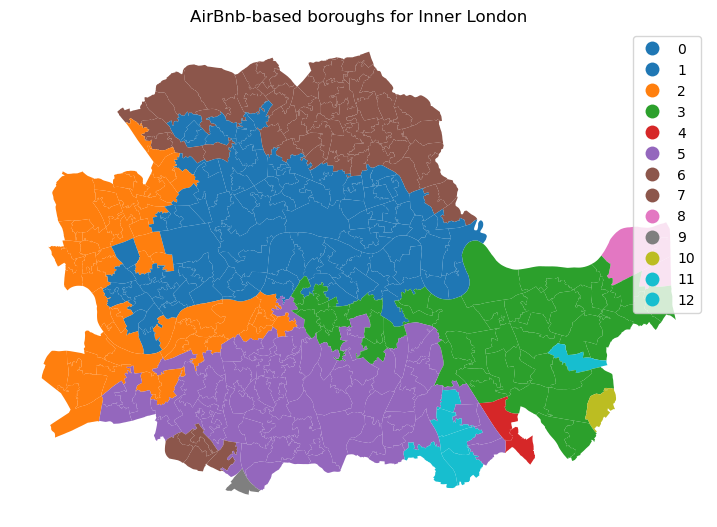

In [ ]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
abb.plot(
    column='sagg13cls', categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('AirBnb-based boroughs for Inner London')
# Display the map
plt.show()

In [ ]:
def dissolve(gs):
    '''
    Take a series of polygons and dissolve them into a single one
    
    Arguments
    ---------
    gs        : GeoSeries
                Sequence of polygons to be dissolved
    Returns
    -------
    dissolved : Polygon
                Single polygon containing all the polygons in `gs`
    '''
    return gs.unary_union

In [ ]:
# Dissolve the polygons based on `sagg13cls`
abb_boroughs = gpd.GeoSeries(
    abb.groupby(abb['sagg13cls']).apply(dissolve),
    crs=abb.crs
)

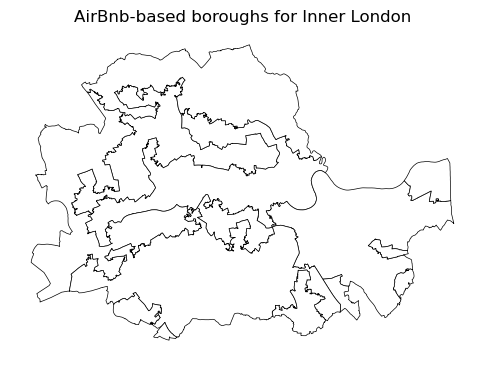

In [ ]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot boundary lines
abb_boroughs.plot(
    ax=ax, 
    linewidth=0.5,
    facecolor='white', 
    edgecolor='k'
)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('AirBnb-based boroughs for Inner London');

/home/siquette/anaconda3/envs/ri/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


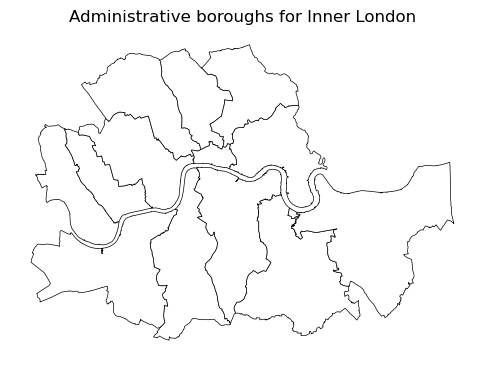

In [ ]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot boundary lines
boroughs.plot(
    ax=ax, 
    linewidth=0.5,
    edgecolor='k', 
    facecolor='white'
)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('Administrative boroughs for Inner London');